# model to file .pkl

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
mpl_df = pd.read_csv("/content/mpl_id_s14.csv")
attributes_df = pd.read_csv("/content/mlbb_heroes_attribute.csv")

In [ ]:
# drop unused columns
mpl_df.drop(columns=['no','week','date','match','game','match_length','blue_team','red_team'], inplace=True)

In [ ]:
# remove unused columns from dataset
attributes_df.drop(columns=['id','main_role','secondary_role','main_damage_type'], inplace=True)

In [ ]:
def feature_engineering(mpl_df, attribute_df):
    # Buat dictionary hero untuk lookup cepat
    attribute_dict = attribute_df.set_index('hero')[['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']].to_dict('index')

    # Fungsi untuk menghitung total atribut untuk setiap tim
    def sum_attributes(row, side):
        positions = ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']
        features = ['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']
        side_sums = {f"{side}_{feature}": sum(attribute_dict.get(row[f"{side}_{pos}"], {}).get(feature, 0) for pos in positions) for feature in features}
        return pd.Series(side_sums)

    # Apply fungsi sum_attributes untuk blue dan red team
    blue_features = mpl_df.apply(lambda row: sum_attributes(row, 'blue'), axis=1)
    red_features = mpl_df.apply(lambda row: sum_attributes(row, 'red'), axis=1)

    # Gabungkan hasil ke dalam mpl_df
    mpl_df = pd.concat([mpl_df, blue_features, red_features], axis=1)

    # Hitung total power spike
    mpl_df['blue_total_power_spike'] = mpl_df[['blue_early', 'blue_mid', 'blue_late']].sum(axis=1)
    mpl_df['red_total_power_spike'] = mpl_df[['red_early', 'red_mid', 'red_late']].sum(axis=1)

    # Tambahkan perbedaan atribut
    mpl_df['durability_diff'] = mpl_df['blue_durability'] - mpl_df['red_durability']
    mpl_df['offense_diff'] = mpl_df['blue_offense'] - mpl_df['red_offense']
    mpl_df['control_effects_diff'] = mpl_df['blue_control_effects'] - mpl_df['red_control_effects']
    mpl_df['difficulty_diff'] = mpl_df['blue_difficulty'] - mpl_df['red_difficulty']
    mpl_df['power_spike_diff'] = mpl_df['blue_total_power_spike'] - mpl_df['red_total_power_spike']

    # Rata-rata nilai untuk role per team
    for feature in ['durability', 'offense']:
        mpl_df[f'blue_avg_{feature}'] = mpl_df[f'blue_{feature}'] / 5
        mpl_df[f'red_avg_{feature}'] = mpl_df[f'red_{feature}'] / 5

    # Aggressiveness score
    mpl_df['blue_aggressiveness_score'] = mpl_df['blue_offense'] / mpl_df['blue_durability']
    mpl_df['red_aggressiveness_score'] = mpl_df['red_offense'] / mpl_df['red_durability']

    # Perbandingan early-mid dan mid-late untuk kedua tim
    for side in ['blue', 'red']:
        mpl_df[f'{side}_early_mid_ratio'] = np.where(mpl_df[f'{side}_mid'] == 0, 1, mpl_df[f'{side}_early'] / mpl_df[f'{side}_mid'])
        mpl_df[f'{side}_mid_late_ratio'] = np.where(mpl_df[f'{side}_late'] == 0, 1, mpl_df[f'{side}_mid'] / mpl_df[f'{side}_late'])

    # Drop kolom posisi yang tidak dipakai
    mpl_df.drop(columns=[f'{side}_{pos}' for side in ['blue', 'red'] for pos in ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']], inplace=True)

    # Drop kolom atribut yang sudah dihitung
    drop_columns = [
        'blue_durability', 'blue_offense', 'blue_control_effects', 'blue_difficulty',
        'red_durability', 'red_offense', 'red_control_effects', 'red_difficulty',
        'blue_total_power_spike', 'red_total_power_spike',
        'blue_early', 'blue_mid', 'blue_late',
        'red_early', 'red_mid', 'red_late'
    ]
    mpl_df.drop(columns=drop_columns, inplace=True)

    return mpl_df.round(3)


In [ ]:
mpl_df_transformed = feature_engineering(mpl_df, attributes_df)
mpl_df_transformed.head()

,result,durability_diff,offense_diff,control_effects_diff,difficulty_diff,power_spike_diff,blue_avg_durability,red_avg_durability,blue_avg_offense,red_avg_offense,blue_aggressiveness_score,red_aggressiveness_score,blue_early_mid_ratio,blue_mid_late_ratio,red_early_mid_ratio,red_mid_late_ratio
0,RED,1,-1,12,-11,0,5.4,5.2,5.2,5.4,0.963,1.038,0.667,1.0,1.0,1.500
1,BLUE,5,-4,-1,4,0,5.8,4.8,5.0,5.8,0.862,1.208,0.750,4.0,0.5,2.000
2,BLUE,6,1,2,1,2,6.2,5.0,5.2,5.0,0.839,1.000,0.750,2.0,1.0,3.000
3,RED,3,3,6,2,-1,5.4,4.8,6.0,5.4,1.111,1.125,1.000,1.5,0.5,1.333
4,BLUE,4,2,20,2,-3,5.8,5.0,5.6,5.2,0.966,1.040,1.000,3.0,0.2,1.250


In [ ]:
mpl_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   result                     212 non-null    object 
 1   durability_diff            212 non-null    int64  
 2   offense_diff               212 non-null    int64  
 3   control_effects_diff       212 non-null    int64  
 4   difficulty_diff            212 non-null    int64  
 5   power_spike_diff           212 non-null    int64  
 6   blue_avg_durability        212 non-null    float64
 7   blue_avg_offense           212 non-null    float64
 8   blue_aggressiveness_score  212 non-null    float64
 9   blue_early_mid_ratio       212 non-null    float64
 10  blue_mid_late_ratio        212 non-null    float64
 11  red_avg_durability         212 non-null    float64
 12  red_avg_offense            212 non-null    float64
 13  red_aggressiveness_score   212 non-null    float64

In [ ]:
mpl_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   result                     212 non-null    object 
 1   durability_diff            212 non-null    int64  
 2   offense_diff               212 non-null    int64  
 3   control_effects_diff       212 non-null    int64  
 4   difficulty_diff            212 non-null    int64  
 5   power_spike_diff           212 non-null    int64  
 6   blue_avg_durability        212 non-null    float64
 7   red_avg_durability         212 non-null    float64
 8   blue_avg_offense           212 non-null    float64
 9   red_avg_offense            212 non-null    float64
 10  blue_aggressiveness_score  212 non-null    float64
 11  red_aggressiveness_score   212 non-null    float64
 12  blue_early_mid_ratio       212 non-null    float64
 13  blue_mid_late_ratio        212 non-null    float64

In [ ]:
# Misalkan 'result' adalah target variable
X = mpl_df_transformed.drop(columns=['result'])  # Semua kolom kecuali 'result'
y = mpl_df_transformed['result']  # Kolom target

# Split dataset 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Cek ukuran dari masing-masing dataset
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 159
Test set size: 53


In [ ]:
# Train model with Random Forest
rf_model = RandomForestClassifier(
    random_state=91,
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=8,
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, min_samples_leaf=8, n_estimators=50,
                       random_state=91)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
# accuration
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=rf_model.classes_)
print('Confusion Matrix:')
print(cm)
print()

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.70

Confusion Matrix:
[[18  9]
 [ 7 19]]

Classification Report:
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53



In [ ]:
print(y_pred)
print(y_test.values)

['BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'RED' 'RED' 'RED' 'RED' 'RED'
 'RED' 'RED' 'RED' 'RED' 'BLUE' 'RED' 'BLUE' 'BLUE' 'BLUE' 'BLUE' 'BLUE'
 'RED' 'RED' 'BLUE' 'BLUE' 'BLUE' 'BLUE' 'RED' 'BLUE' 'BLUE' 'RED' 'BLUE'
 'BLUE' 'BLUE' 'RED' 'RED' 'RED' 'RED' 'BLUE' 'RED' 'RED' 'RED' 'BLUE'
 'BLUE' 'BLUE' 'RED' 'RED' 'BLUE' 'BLUE' 'BLUE' 'RED' 'RED']
['BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE'
 'RED' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'BLUE' 'BLUE' 'RED'
 'BLUE' 'RED' 'BLUE' 'RED' 'RED' 'BLUE' 'RED' 'BLUE' 'RED' 'RED' 'BLUE'
 'RED' 'RED' 'BLUE' 'BLUE' 'RED' 'RED' 'BLUE' 'RED' 'RED' 'BLUE' 'BLUE'
 'BLUE' 'BLUE' 'BLUE' 'RED' 'BLUE' 'BLUE' 'BLUE' 'RED' 'RED']


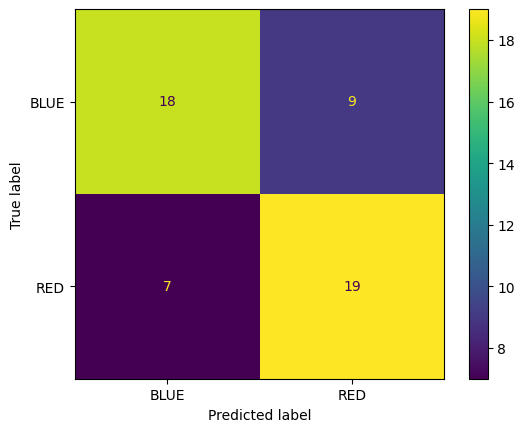

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

In [ ]:
import joblib

# Menyimpan model
joblib.dump(rf_model, 'model_rf.pkl')

['model_rf.pkl']

In [ ]:
# Memuat model
load_model = joblib.load('model_rf.pkl')

In [ ]:
y_pred = load_model.predict(X_test)

In [ ]:
# accuration
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=rf_model.classes_)
print('Confusion Matrix:')
print(cm)
print()

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.70

Confusion Matrix:
[[18  9]
 [ 7 19]]

Classification Report:
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53

